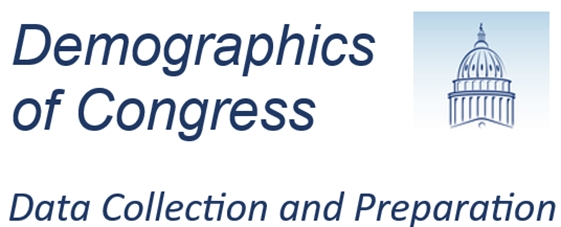
***  
# Introduction  
The Brookings Institute maintains a large dataset known as ***Vital Statistics on Congress***, which contains a variety of demographics on each Congress. A subset of this data has been collected and merged to help identify correlations between the makeup of Congress and it's productivity as measured by the number of laws enacted.

For this project, Chapter 1 of ***Vital Statistics*** was downloaded from the <a href="https://www.brookings.edu/articles/vital-statistics-on-congress/">Brookings Institute</a> in Excel format.

***
# Notebook Setup
***

In [58]:
# Import libraries
import pandas as pd
import re
import statistics as stats

In [59]:
# This notebook requires openpyxl. If you do not have this installed, uncomment the following install command
#!pip install openpyxl

In [60]:
# Set options
pd.options.display.multi_sparse = False
pd.options.display.max_colwidth = 25

In [61]:
%%html
<!-- Prevent text wrappping in dataframe displays for a cleaner print -->
<style> .dataframe td {white-space: nowrap;}</style>

***  
# Party
***

In [62]:
# Read party data
file_name = '../Data/Vital Statistics on Congress.xlsx'
raw_party_dict = pd.read_excel(file_name, sheet_name='1-20', skiprows=2, header=[0,1])
party_df = pd.DataFrame(raw_party_dict)
pd.concat([party_df.head(5), party_df.tail(5)])

,Unnamed: 0_level_0,Unnamed: 1_level_0,Senate,Senate,Senate,Senate,Senate,Senate,House of Representatives,House of Representatives,House of Representatives,House of Representatives,House of Representatives
,Congress,Congress,Number of senators,Democrats,Republicans,Other parties,Vacant,Vacant.1,Number of representatives,Democrats,Republicans,Other parties,Vacant
0,34th,(1855 - 1857),62.0,42.0,15.0,5.0,NaN,NaN,234,83,108.0,43.0,NaN
1,35th,(1857 - 1859),64.0,39.0,20.0,5.0,NaN,NaN,237,131,92.0,14.0,NaN
2,36th,(1859 - 1861),66.0,38.0,26.0,2.0,NaN,NaN,237,101,113.0,23.0,NaN
3,37th,(1861 - 1863),50.0,11.0,31.0,7.0,1.0,NaN,178,42,106.0,28.0,2.0
4,38th,(1863 - 1865),51.0,12.0,39.0,NaN,NaN,NaN,183,80,103.0,NaN,NaN
82,116th,(2019 - 2021),100.0,45.0,53.0,2.0,NaN,NaN,434e,235,199.0,NaN,1.0
83,117thf,(2021 - 2023),100.0,48.0,50.0,2.0,NaN,NaN,433,222,211.0,NaN,2.0
84,NaN,Note: Figures represe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,a. Democrats organize...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Drop the last 3 rows on the dataset, which contain footnotes
party_df.drop(index=[84, 85, 86], inplace=True)

In [64]:
# Create a temporary dataframe with just Senate data, delele empty columns, and rename the headings
party_sen_df = party_df[['Unnamed: 0_level_0', 'Senate']].copy()
party_sen_df.drop(('Senate', 'Vacant.1'), axis=1, inplace=True)
party_sen_df.columns = ['Congress', 'Total Members', 'Democrats', 'Republicans', 'Other Party', 'Vacancies']  
party_sen_df.head()

,Congress,Total Members,Democrats,Republicans,Other Party,Vacancies
0,34th,62.0,42.0,15.0,5.0,NaN
1,35th,64.0,39.0,20.0,5.0,NaN
2,36th,66.0,38.0,26.0,2.0,NaN
3,37th,50.0,11.0,31.0,7.0,1.0
4,38th,51.0,12.0,39.0,NaN,NaN


In [65]:
# Add a Chamber column and populate
party_sen_df.insert(loc=1, column='Chamber', value='Senate')
party_sen_df.head()

,Congress,Chamber,Total Members,Democrats,Republicans,Other Party,Vacancies
0,34th,Senate,62.0,42.0,15.0,5.0,NaN
1,35th,Senate,64.0,39.0,20.0,5.0,NaN
2,36th,Senate,66.0,38.0,26.0,2.0,NaN
3,37th,Senate,50.0,11.0,31.0,7.0,1.0
4,38th,Senate,51.0,12.0,39.0,NaN,NaN


In [66]:
# Repeat the same process for the House data
# Create a temporary dataframe with just Senate data, delele empty columns, and rename the headings
party_house_df = party_df[['Unnamed: 0_level_0', 'House of Representatives']].copy()
party_house_df.columns = ['Congress', 'Total Members', 'Democrats', 'Republicans', 'Other Party', 'Vacancies']  
party_house_df.insert(loc=1, column='Chamber', value='House')
party_house_df.head()

,Congress,Chamber,Total Members,Democrats,Republicans,Other Party,Vacancies
0,34th,House,234,83,108.0,43.0,NaN
1,35th,House,237,131,92.0,14.0,NaN
2,36th,House,237,101,113.0,23.0,NaN
3,37th,House,178,42,106.0,28.0,2.0
4,38th,House,183,80,103.0,NaN,NaN


In [67]:
# Merge the data into a new dataframe
demog_df = pd.concat([party_house_df, party_sen_df])
demog_df

,Congress,Chamber,Total Members,Democrats,Republicans,Other Party,Vacancies
0,34th,House,234,83,108.0,43.0,NaN
1,35th,House,237,131,92.0,14.0,NaN
2,36th,House,237,101,113.0,23.0,NaN
3,37th,House,178,42,106.0,28.0,2.0
4,38th,House,183,80,103.0,NaN,NaN
...,...,...,...,...,...,...,...
79,113th,Senate,100.0,53.0,45.0,2.0,NaN
80,114th,Senate,100.0,44.0,54.0,2.0,NaN
81,115th,Senate,100.0,46.0,52.0,2.0,NaN
82,116th,Senate,100.0,45.0,53.0,2.0,NaN


In [68]:
# Review the Congress data and indentify any items that need to be cleaned up 
demog_df['Congress'].values

array(['34th', '35th', '36th', '37th', '38th', '39th', '40th', '41st',
       '42nd', '43rd', '44th', '45th', '46th', '47th', '48th', '49th',
       '50th', '51st', '52nd', '53rd', '54th', '55th', '56th', '57th',
       '58th', '59th', '60th', '61st', '62nd', '63rd', '64th', '65th',
       '66th', '67th', '68th', '69th', '70th', '71st', '72nd', '73rd',
       '74th', '75th', '76th', '77th', '78th', '79th', '80th', '81st',
       '82nd', '83rd', '84th', '85th', '86th', '87th', '88th', '89th',
       '90th', '91st', '92nd', '93rd', '94th', '95th', '96th', '97th',
       '98th', '99th', '100th', '101st', '102nd', '103rd', '104th',
       '105th', '106th ', '107th ', '108th', '109th', '110th', '111th',
       '112th', '113th', '114th', '115th', '116th', '117thf', '34th',
       '35th', '36th', '37th', '38th', '39th', '40th', '41st', '42nd',
       '43rd', '44th', '45th', '46th', '47th', '48th', '49th', '50th',
       '51st', '52nd', '53rd', '54th', '55th', '56th', '57th', '58th',
       '5

In [69]:
# Strip the alphabetic characters from the Congress data and set dtype to int
demog_df['Congress'] = demog_df['Congress'].str.extract(r'(\d*).*')
demog_df['Congress'] = demog_df['Congress'].astype(int)

In [70]:
# Review the Chamber data and indentify any items that need to be cleaned up
demog_df['Chamber'].unique()

array(['House', 'Senate'], dtype=object)

In [71]:
# Revew the Total Members data and identify any items that need to be cleaned up
demog_df['Total Members'].values

array([234, 237, 237, 178, 183, 191, 193, 243, 243, 293, 293, 293, 293,
       293, 325, 325, 325, 330, 333, 356, 357, 357, 357, 357, 386, 386,
       386, 391, 391, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435,
       435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435,
       '436c', '437d', 435, 435, 435, 435, 435, 435, 435, 435, 435, 435,
       435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435,
       435, 435, 435, 435, 435, '434e', 433, 62.0, 64.0, 66.0, 50.0, 51.0,
       52.0, 53.0, 74.0, 74.0, 74.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0,
       76.0, 84.0, 88.0, 88.0, 88.0, 90.0, 90.0, 90.0, 90.0, 90.0, 92.0,
       92.0, 92.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0,
       96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0,
       96.0, 96.0, 96.0, 98.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,
       100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,
       100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1

In [72]:
# Strip the alphabetic characters from the Total Members data and set dtype to int
demog_df['Total Members'] = demog_df['Total Members'].astype(str)
demog_df['Total Members'] = demog_df['Total Members'].str.extract(r'(\d*).*')
demog_df['Total Members'] = demog_df['Total Members'].astype(int)

In [73]:
# Review the Democrats column data and indentify any items that need to be cleaned up
demog_df['Democrats'].values

array([83, 131, 101, 42, 80, 46, 49, 73, 104, 88, 181, 156, 150, 130, 200,
       182, 170, 156, 231, 220, 104, 134, 163, 153, 178, 136, 164, 172,
       228, 290, 231, '210a', 191, 132, 207, 183, 195, 163, '216b', 313,
       322, 333, 262, 267, 222, 243, 188, 263, 234, 213, 232, 234, 283,
       262, 258, 295, 246, 243, 255, 239, 291, 292, 276, 243, 268, 252,
       258, 259, 267, 258, 204, 207, 211, 211, 205, 201, 233, 256, 193,
       200, 188, 194, 235, 222, 42.0, 39.0, 38.0, 11.0, 12.0, 10.0, 11.0,
       11.0, 17.0, 19.0, 29.0, 36.0, 43.0, 37.0, 36.0, 34.0, 37.0, 37.0,
       39.0, 44.0, 39.0, 34.0, 26.0, 29.0, 32.0, 32.0, 29.0, 32.0, 42.0,
       51.0, 56.0, 53.0, 47.0, 37.0, 43.0, 40.0, 47.0, 39.0, 47.0, 59.0,
       69.0, 75.0, 69.0, 66.0, 57.0, 57.0, 45.0, 54.0, 48.0, 46.0, 48.0,
       49.0, 64.0, 64.0, 67.0, 68.0, 64.0, 58.0, 54.0, 56.0, 61.0, 61.0,
       58.0, 46.0, 46.0, 47.0, 55.0, 55.0, 56.0, 57.0, 47.0, 45.0, 45.0,
       50.0, 48.0, 44.0, 49.0, 55.0, 51.0, 53.0, 44.

In [74]:
# Strip the alphabetic characters from the Democrats column data and set dtype to int
demog_df['Democrats'] = demog_df['Democrats'].astype(str)
demog_df['Democrats'] = demog_df['Democrats'].str.extract(r'(\d*).*')
demog_df['Democrats'] = demog_df['Democrats'].astype(int)

In [75]:
# Review the Republicans column data and indentify any items that need to be cleaned up
demog_df['Republicans'].values

array([108.,  92., 113., 106., 103., 145., 143., 170., 139., 203., 107.,
       137., 128., 152., 119., 140., 151., 173.,  88., 126., 246., 206.,
       185., 198., 207., 250., 222., 219., 162., 127., 193., 216., 237.,
       300., 225., 247., 237., 267., 218., 117., 103.,  89., 169., 162.,
       209., 190., 246., 171., 199., 221., 203., 201., 153., 175., 176.,
       140., 187., 192., 180., 192., 144., 143., 157., 192., 166., 182.,
       177., 174., 167., 176., 230., 227., 223., 221., 229., 232., 202.,
       178., 242., 233., 247., 241., 199., 211.,  15.,  20.,  26.,  31.,
        39.,  42.,  42.,  61.,  57.,  54.,  46.,  39.,  33.,  37.,  40.,
        41.,  39.,  47.,  47.,  38.,  44.,  46.,  53.,  56.,  58.,  58.,
        61.,  59.,  49.,  44.,  39.,  42.,  48.,  59.,  51.,  54.,  48.,
        56.,  48.,  36.,  25.,  17.,  23.,  28.,  38.,  38.,  51.,  42.,
        47.,  48.,  47.,  47.,  34.,  36.,  33.,  32.,  36.,  42.,  44.,
        42.,  37.,  38.,  41.,  53.,  54.,  53.,  4

In [76]:
# Set the Republicans column dtype to int
demog_df['Republicans'] = demog_df['Republicans'].astype(int)

In [77]:
# Review the Other Party column data and indentify any items that need to be cleaned up
demog_df['Other Party'].values

array([43., 14., 23., 28., nan, nan, nan, nan, nan, nan,  3., nan, 14.,
       11.,  6.,  2.,  4.,  1., 14., 10.,  7., 16.,  9.,  5., nan, nan,
       nan, nan,  1., 18.,  8.,  9.,  7.,  1.,  3.,  5.,  3.,  1.,  1.,
        5., 10., 13.,  4.,  6.,  4.,  2.,  1.,  1.,  2.,  1., nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  1., nan, nan, nan, nan, nan,
       nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1., nan, nan,
       nan, nan, nan, nan, nan, nan,  5.,  5.,  2.,  7., nan, nan, nan,
       nan, nan, nan, nan,  1., nan,  2., nan, nan, nan, nan,  2.,  3.,
        5., 10., 11.,  3., nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,
       nan,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,  4.,  2.,  1.,  1.,
       nan, nan,  1.,  2.,  1., nan, nan, nan, nan, nan, nan, nan,  2.,
        2.,  2.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [78]:
# Replace nan values in the Other Party column with 0 and set the dtype to int
demog_df['Other Party'].fillna(0, inplace=True)
demog_df['Other Party'] = demog_df['Other Party'].astype(int)

In [79]:
# Review the Vacancies column data and indentify any items that need to be cleaned up
demog_df['Vacancies'].values

array([nan, nan, nan,  2., nan, nan,  1., nan, nan,  2.,  2., nan,  1.,
       nan, nan,  1., nan, nan, nan, nan, nan,  1., nan,  1.,  1., nan,
       nan, nan, nan, nan,  3., nan, nan,  2., nan, nan, nan,  4., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  1., nan,  2., nan, nan,  3., nan, nan,  2., nan,  1.,
        1., nan,  2., nan, nan, nan, nan, nan,  1., nan,  1., nan,  1.,
       nan,  2., nan, nan,  1.,  2., nan, nan, nan,  1., nan, nan, nan,
        2., nan,  1.,  1., nan, nan, nan, nan,  1., nan, nan, nan,  3.,
       nan, nan, nan,  2., nan, nan,  2.,  1.,  1., nan, nan, nan, nan,
       nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan])

In [80]:
# Replace nan values in the Vacancies column with 0 and set the dtype to int
demog_df['Vacancies'].fillna(0, inplace=True)
demog_df['Vacancies'] = demog_df['Vacancies'].astype(int)

In [81]:
# Set the dataframe index to Congress and Chamber and preview final party data
demog_df.set_index(['Congress', 'Chamber'], drop=True, inplace=True)
demog_df.head()

,,Total Members,Democrats,Republicans,Other Party,Vacancies
Congress,Chamber,,,,,
34,House,234,83,108,43,0
35,House,237,131,92,14,0
36,House,237,101,113,23,0
37,House,178,42,106,28,2
38,House,183,80,103,0,0


***
# Senority
***

In [82]:
# Read Senority data for the House
file_name = '../Data/Vital Statistics on Congress.xlsx'
raw_senority_reps_dict = pd.read_excel(file_name, sheet_name='1-6', skiprows=3)
senority_reps_df = pd.DataFrame(raw_senority_reps_dict)
pd.concat([senority_reps_df.head(5), senority_reps_df.tail(5)])

,Congress,1 term,2 terms,3 terms,1 - 3 terms,4 - 6 terms,7 - 9 terms,10 + terms,Total,Mean term,Median term
0,83rd (1953),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Percent,18.706697,16.859122,14.7806,50.34642,27.020785,13.394919,9.237875,NaN,4.5,3.0
2,Seats,81,73.000000,64.0000,218.00000,117.000000,58.000000,40.000000,433a,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84th (1955),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,Percent,13.2,17.300000,12.2000,42.70000,27.900000,12.500000,16.900000,NaN,5.5,4.0
138,Seats,57,75.000000,53.0000,185.00000,121.000000,54.000000,73.000000,433,NaN,NaN
139,NaN,Note: Figures represe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,NaN,a. E.E. Cox (D-GA) an...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,NaN,Source: Congressional...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Delete the last 3 rows of the dataset, which contain footnotes
senority_reps_df.drop(index=[139, 140, 141], inplace=True)

In [84]:
# Drop the Mean and Median columns. We will do our own calculations later on
senority_reps_df.drop(columns=['Mean term', 'Median term'], inplace=True)

In [85]:
# Drop the Total column, as we already have a Total Members column from the Party data
senority_reps_df.drop(columns=['Total'], inplace=True)

In [86]:
# Each observation in the House dataset is split across 3 rows, with only the first row of each observation containing Congress data in the
# Congress column. Let's clean this up by duplicating the Congress column and then populating it correctly
senority_reps_df.rename(columns={'Congress': 'Congress - OLD'}, inplace=True)
for i, row in senority_reps_df.iterrows():
    if i == 0 or i % 4 == 0:
        cong_data = row['Congress - OLD']
    senority_reps_df.loc[i, 'Congress'] = cong_data

In [87]:
# Let's select only the rows that have the value of Seats in the original Congress column. These are the rows that contain the data we're after
senority_reps_df = senority_reps_df.loc[senority_reps_df['Congress - OLD'] == '   Seats'].copy()
senority_reps_df.drop(columns=['Congress - OLD'], inplace=True)

In [88]:
# Replace all NaN values with 0
senority_reps_df.fillna(0, inplace=True)

In [89]:
# Let's combine the 4-6, 7-9 and 10+ columns into a single column indicating the number of members serving 4 or more terms. This
# will be important later, as the Senate dataset does not have the same divisions of senority
senority_reps_df['4+ terms'] = senority_reps_df.loc[:, '4 - 6 terms':'10 + terms'].sum(axis=1)
senority_reps_df.drop(columns=['1 - 3 terms', '4 - 6 terms', '7 - 9 terms', '10 + terms'], inplace=True)

In [90]:
# Review the Congress column data and identify any items that need to be cleaned up
senority_reps_df['Congress'].values

array(['83rd (1953)', '84th (1955)', '85th (1957)', '86th (1959)',
       '87th (1961)', '88th (1963)', '89th (1965)', '90th (1967)',
       '91st (1969)', '92nd (1971)', '93rd (1973)', '94th (1975)',
       '95th (1977)', '96th (1979)', '97th (1981)', '98th (1983)',
       '99th (1985)', '100th (1987)', '101st (1989)', '102nd (1991)',
       '103rd (1993)', '104th (1995)', '105th (1997)', '106th (1999)',
       '107th (2001)', '108th (2003)', '109th (2005)', '110th (2007)',
       '111th (2009)', '112th (2011)', '113th (2013)', '114th (2015)',
       '115th (2017)', '116th (2019)', '117th (2021)'], dtype=object)

In [91]:
# Extract just the Congress number from the Congress column data
senority_reps_df['Congress'] = senority_reps_df['Congress'].str.extract(r'(\d*).*')

In [92]:
# Review the 1 Term column data and identify any items that need to be cleaned up
senority_reps_df['1 term'].values

array([ 81,  57,  46,  82,  62,  67,  91,  72,  40,  56,  69,  92,  67,
        77,  74,  80,  43,  50,  33,  44, 110,  86,  79,  41,  40,  62,
        43,  57,  54,  89,  72,  56,  51,  85,  57], dtype=int64)

In [93]:
# Review the 2 Terms column data and identify any items that need to be cleaned up
senority_reps_df['2 terms'].values

array([73., 73., 50., 45., 65., 62., 58., 64., 75., 42., 55., 64., 94.,
       64., 76., 64., 79., 38., 54., 41., 44., 97., 76., 75., 41., 41.,
       50., 43., 58., 42., 85., 73., 60., 57., 75.])

In [94]:
# Review the 3 Terms column data and identify any items that need to be cleaned up
senority_reps_df['3 terms'].values

array([64., 63., 66., 49., 36., 53., 49., 47., 56., 64., 38., 40., 58.,
       78., 59., 66., 62., 75., 33., 48., 38., 37., 88., 69., 68., 46.,
       44., 49., 35., 39., 39., 76., 66., 42., 53.])

In [95]:
# Review the 4 + Terms column data and identify any items that need to be cleaned up
senority_reps_df['4+ terms'].values

array([215., 242., 271., 257., 274., 252., 237., 250., 264., 273., 270.,
       239., 216., 214., 226., 224., 250., 272., 313., 302., 243., 215.,
       192., 250., 285., 286., 297., 286., 287., 263., 237., 230., 258.,
       250., 248.])

In [96]:
# Convert all columns in the dataset to int
senority_reps_df = senority_reps_df.astype(int)

In [97]:
# Add Chamber column and set index to match demog_df
senority_reps_df['Chamber'] = 'House'
senority_reps_df.set_index(['Congress', 'Chamber'], drop=True, inplace=True)
senority_reps_df.head()

,,1 term,2 terms,3 terms,4+ terms
Congress,Chamber,,,,
83,House,81,73,64,215
84,House,57,73,63,242
85,House,46,50,66,271
86,House,82,45,49,257
87,House,62,65,36,274


***
Repeat the same process for the Senate Senority data.
***

In [98]:
# Read Senority data for the Senate
file_name = '../Data/Vital Statistics on Congress.xlsx'
raw_senority_sens_dict = pd.read_excel(file_name, sheet_name='1-7', skiprows=3)
senority_sens_df = pd.DataFrame(raw_senority_sens_dict)
pd.concat([senority_sens_df.head(5), senority_sens_df.tail(5)])

,Congress,Unnamed: 1,6 years or less,7 - 12 years,13 - 18 years,19 years or more,Total,Mean years service,Median years service
0,83rd,(1953),46 (16),29.0,14.0,7.0,96.0,8.50,7.0
1,84th,(1955),42 (14),37.0,8.0,9.0,96.0,8.40,7.0
2,85th,(1957),37 (10),36.0,13.0,10.0,96.0,9.60,9.0
3,86th,(1959),42 (20),30.0,14.0,12.0,98.0,9.40,8.0
4,87th,(1961),42 (7),25.0,22.0,11.0,100.0,9.70,9.0
33,116th,(2019),32(9),33.0,17.0,18.0,100.0,10.10,8.0
34,117thc,(2021),26 (8),37.0,18.0,19.0,100.0,11.96,10.5
35,NaN,Note: Figures in pare...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,a. Total includes Joh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,Source: Congressional...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Delete the last 3 rows of the dataset, which contain footnotes
senority_sens_df.drop(index=[35, 36, 37], inplace=True)

In [100]:
# Drop the Unnamed column, which contains the year
senority_sens_df.drop(columns=['Unnamed: 1'], inplace=True)

In [101]:
# Drop the Mean and Median columns. We will do our own calculations later on
senority_sens_df.drop(columns=['Mean years service', 'Median years service'], inplace=True)

In [102]:
# Drop the Total column, as we already have a Total Members column from the Party data
senority_sens_df.drop(columns=['Total'], inplace=True)

In [103]:
# Replace all NaN values with 0
senority_sens_df.fillna(0, inplace=True)

In [104]:
# Rename the length of service columns for consistency with teh House data
senority_sens_df.rename(columns={'6 years or less': '1 term', '7 - 12 years': '2 terms', 
                                 '13 - 18 years': '3 terms', '19 years or more': '4+ terms'}, inplace=True)

In [105]:
# Review the Congress column data and identify any items that need to be cleaned up
senority_sens_df['Congress'].values

array(['83rd', '84th', '85th', '86th', '87th', '88th', '89th', '90th',
       '91st', '92nd', '93rd', '94th', '95th', '96th', '97th', '98th',
       '99th', '100th', '101st', '102nd', '103rd', '104th', '105th',
       '106th', '107th ', '108th', '109th', '110th', '111th', '112th',
       '113th', '114th', '115th', '116th', '117thc'], dtype=object)

In [106]:
# Extract just the Congress number from the Congress column data
senority_sens_df['Congress'] = senority_sens_df['Congress'].str.extract(r'(\d*).*')

In [107]:
# Review the 1 Term column data and identify any items that need to be cleaned up
senority_sens_df['1 term'].values

array(['46 (16)', '42 (14)', '37 (10)', '42 (20)', '42 (7)', '42 (12)',
       '29 (8)', '28 (7)', '32 (14)', '25 (10)', '40 (13)', '36 (12)a',
       '42 (17)', '48 (20)', '55 (18)', '43 (5)', '32 (7)', '26 (13)',
       '31 (10)', '30 (5)', '30 (13)', '29 (11)', '40 (15)', '35 (8)',
       '37 (11)', '30 (10)', '29 (9)', '29 (10)', '32 (11)', '42 (13)',
       '43 (13)', '45 (13)', '36 (7)', '32(9)', '26 (8)'], dtype=object)

In [108]:
# Remove the second in the 1 term column. The dataset distinguishes between freshmen senators and senators who have served 6
# years or less. We are not going to use this distinction
senority_sens_df['1 term'] = senority_sens_df['1 term'].str.extract(r'(\d*).*')

In [109]:
# Review the 2 Terms column data and identify any items that need to be cleaned up
senority_sens_df['2 terms'].values

array([29., 37., 36., 30., 25., 26., 36., 34., 32., 24., 20., 22., 25.,
       24., 20., 28., 38., 44., 26., 23., 17., 26., 24., 24., 21., 29.,
       27., 26., 19., 17., 23., 24., 34., 33., 37.])

In [110]:
# Review the 3 Terms column data and identify any items that need to be cleaned up
senority_sens_df['3 terms'].values

array([14.,  8., 13., 14., 22., 18., 16., 19., 17., 29., 20., 23., 13.,
       10., 10., 16., 18., 16., 29., 28., 32., 20., 13., 16., 19., 16.,
       15., 14., 20., 14., 15., 11., 11., 17., 18.])

In [111]:
# Review the 4 + Terms column data and identify any items that need to be cleaned up
senority_sens_df['4+ terms'].values

array([ 7.,  9., 10., 12., 11., 14., 19., 19., 19., 22., 20., 19., 20.,
       18., 15., 13., 12., 14., 14., 19., 21., 25., 23., 25., 23., 25.,
       29., 31., 29., 27., 19., 20., 19., 18., 19.])

In [112]:
# Convert all columns in the dataset to int
senority_sens_df = senority_sens_df.astype(int)

In [113]:
senority_sens_df.head()

,Congress,1 term,2 terms,3 terms,4+ terms
0,83,46,29,14,7
1,84,42,37,8,9
2,85,37,36,13,10
3,86,42,30,14,12
4,87,42,25,22,11


In [115]:
# Add Chamber column and set index to match demog_df
senority_sens_df['Chamber'] = 'Senate'
senority_sens_df.set_index(['Congress', 'Chamber'], drop=True, inplace=True)

,,1 term,2 terms,3 terms,4+ terms
Congress,Chamber,,,,
83,Senate,46,29,14,7
84,Senate,42,37,8,9
85,Senate,37,36,13,10
86,Senate,42,30,14,12
87,Senate,42,25,22,11


In [117]:
# Concat senority dataframes, then concat to demographics dataframe
senority_df = pd.concat([senority_reps_df, senority_sens_df])
demog_df = pd.concat([demog_df, senority_df], axis=1)
pd.concat([demog_df.head(5), demog_df.tail(5)])

,,Total Members,Democrats,Republicans,Other Party,Vacancies,1 term,2 terms,3 terms,4+ terms,1 term,2 terms,3 terms,4+ terms
Congress,Chamber,,,,,,,,,,,,,
34,House,234,83,108,43,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,House,237,131,92,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,House,237,101,113,23,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,House,178,42,106,28,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,House,183,80,103,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,Senate,100,53,45,2,0,43.0,23.0,15.0,19.0,43.0,23.0,15.0,19.0
114,Senate,100,44,54,2,0,45.0,24.0,11.0,20.0,45.0,24.0,11.0,20.0
115,Senate,100,46,52,2,0,36.0,34.0,11.0,19.0,36.0,34.0,11.0,19.0
116,Senate,100,45,53,2,0,32.0,33.0,17.0,18.0,32.0,33.0,17.0,18.0


***
# Gender
*** 

In [158]:
# Read Senority data for the House
file_name = '../Data/Vital Statistics on Congress.xlsx'
raw_gender_dict = pd.read_excel(file_name, sheet_name='1-19', skiprows=2, header=[0,1])
gender_df = pd.DataFrame(raw_gender_dict)
pd.concat([gender_df.head(5), gender_df.tail(5)])

,Unnamed: 0_level_0,Unnamed: 1_level_0,House,House,House,Senate,Senate,Senate,Senate,Senate,House,House,House,Senate,Senate
,Congress,Congress,D,R,R.1,D,R,R.1,Congress,Congress.1,D.1,R.2,R.3,D.1,R.2
0,65th,(1917),NaN,1.0,NaN,NaN,NaN,NaN,92nd,(1971),10.0,3.0,NaN,NaN,1.0
1,66th,(1919),NaN,NaN,NaN,NaN,NaN,NaN,93rd,(1973),14.0,2.0,NaN,1.0,NaN
2,67th,(1921),NaN,2.0,NaN,NaN,1.0,NaN,94th,(1975),14.0,5.0,NaN,NaN,NaN
3,68th,(1923),NaN,1.0,NaN,NaN,NaN,NaN,95th,(1977),13.0,5.0,NaN,NaN,NaN
4,69th,(1925),1.0,2.0,NaN,NaN,NaN,NaN,96th,(1979),11.0,5.0,NaN,1.0,1.0
25,90th,(1967),5.0,5.0,NaN,NaN,1.0,NaN,117tha,(2021),89.0,29.0,NaN,17.0,8.0
26,91st,(1969),6.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,Note: The data includ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,a. Vital Statistics c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Delete the last 3 rows of the dataset, which contain footnotes
gender_df.drop(index=[27, 28, 29], inplace=True)

In [160]:
# Delete unnecessary columns
gender_df.drop(columns=[('Unnamed: 1_level_0', 'Congress'), ('House', 'R.1'), ('Senate', 'R.1'),
                        ('Senate', 'Congress.1'), ('House', 'R.3')], inplace=True)
gender_df.head()

,Unnamed: 0_level_0,House,House,Senate,Senate,Senate,House,House,Senate,Senate
,Congress,D,R,D,R,Congress,D.1,R.2,D.1,R.2
0,65th,NaN,1.0,NaN,NaN,92nd,10.0,3.0,NaN,1.0
1,66th,NaN,NaN,NaN,NaN,93rd,14.0,2.0,1.0,NaN
2,67th,NaN,2.0,NaN,1.0,94th,14.0,5.0,NaN,NaN
3,68th,NaN,1.0,NaN,NaN,95th,13.0,5.0,NaN,NaN
4,69th,1.0,2.0,NaN,NaN,96th,11.0,5.0,1.0,1.0


In [161]:
# This dataset is setup as two separate sets of columns, so we'll split the dataframe and concat to resolve this
gender_pt1_df = gender_df.iloc[:, 0:5]
gender_pt2_df = gender_df.iloc[:, 5:]
gender_pt1_df.columns = gender_pt2_df.columns = ['Congress', 'House-D', 'House-R', 'Senate-D', 'Senate-R']
gender_df = pd.concat([gender_pt1_df, gender_pt2_df])
gender_df.dropna(how='all', inplace=True)
gender_df

,Congress,House-D,House-R,Senate-D,Senate-R
0,65th,NaN,1.0,NaN,NaN
1,66th,NaN,NaN,NaN,NaN
2,67th,NaN,2.0,NaN,1.0
3,68th,NaN,1.0,NaN,NaN
4,69th,1.0,2.0,NaN,NaN
5,70th,2.0,3.0,NaN,NaN
6,71st,4.0,5.0,NaN,NaN
7,72nd,4.0,3.0,1.0,NaN
8,73rd,4.0,3.0,1.0,NaN
9,74th,4.0,2.0,2.0,NaN


***
# Occupations
***

***
# Write to Excel
***

In [ ]:
#with pd.ExcelWriter('../Data/Resume Data - Scrubbed.xlsx') as writer:
#    gen_activity_tidy_df.to_excel(writer, sheet_name='General Activity', index=False)
#    confirm_tidy_df.to_excel(writer, sheet_name='Confirmations', index=False)

***
**End**
***